<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/05_2)_TF_IDF_%26_Logistic(%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5)_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TF-IDF & Logistic**

In [ ]:
# !pip install pymysql
# !pip install finance-datareader
# !pip install konlpy

In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# DB 연결
# !pip install pymysql
import pymysql

# 실시간 주식가격 데이터
# !pip install finance-datareader
import FinanceDataReader as fdr

# 텍스트 분석
# 1) JAVA 설치, 2) Python 버전과 맞는 JPype1-py3 설치, 3) !pip install konlpy, 4) 설치 경로에서 jvm.py 파일 코드 67번 줄 주석 처리 
from konlpy.tag import Okt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 모델 학습 및 평가
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score

# 모델 저장 및 로드
import joblib

# 기타
import datetime
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## **Read Data**

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/[KD1]D1,2_최종 프로젝트_팀별 산출물관리/6조/Code/텍스트 분석/Data/'
news_18to20 = pd.read_csv(path + 'news_18to20.csv')
news_2021 = pd.read_csv(path + '/news_2021.csv')

news_18to20.shape, news_2021.shape

((52490, 18), (12668, 18))

In [ ]:
df_train = news_18to20.copy()
df_test = news_2021.copy()

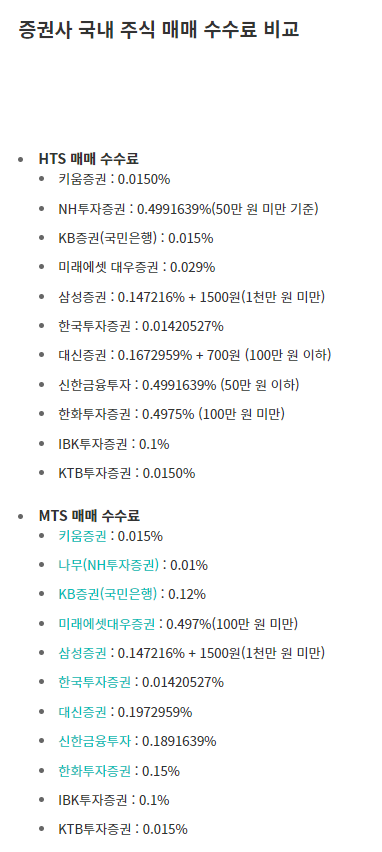

In [ ]:
# 주식 매매 수수료 평균 0.1% 정도? 0을 추가해도 1,-1밖에 안나옴

df_train['soft'] = np.where((df_train.Close * df_train.Change) > (df_train.Close * 0.001), 1,
                            np.where((df_train.Close * df_train.Change) < (df_train.Close * 0.001), -1,1))
df_test['soft'] = np.where((df_test.Close * df_test.Change) > (df_test.Close * 0.001), 1,
                            np.where((df_test.Close * df_test.Change) < (df_test.Close * 0.001), -1,1))

In [ ]:
df_train.soft.value_counts()

-1    26854
 1    25636
Name: soft, dtype: int64

In [ ]:
# https://gist.github.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a#file-stopwords-ko-txt
with open(path+'stopwords-ko.txt', encoding='utf-8') as sw:
    stop_words = sw.readlines()
stop_words = [sw.replace('\n', '') for sw in stop_words]

## **Sentiment Analysis**

### **TF-IDF 기반 벡터화 및 모델 학습**

In [ ]:
df_train.shape

(52490, 19)

In [ ]:
df_train.isna().sum()

st_n                 0
st_cd                0
news                 0
datetime             0
title                0
url                  0
text                 6
date                 0
time                 0
score                0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
Change               0
UpDown               0
Extremely_Changed    0
soft                 0
dtype: int64

In [ ]:
df_train[df_train['Change'].isna()]['date'].value_counts()

Series([], Name: date, dtype: int64)

In [ ]:
df_train[df_train['text'].isna()]

,st_n,st_cd,news,datetime,title,url,text,date,time,score,Open,High,Low,Close,Volume,Change,UpDown,Extremely_Changed,soft
22853,현대차,5380,매일경제,2019021914,"이시한, 취업계 2년 연속 트렌드 예측 경향성 소름 돋는 적중, ‘문어시한’이 떴다...",http://edu.mk.co.kr/edunews/news_view.php?sc=5...,NaN,2019-02-19,14,0,119500,120500,119000,119500,470357,-0.008299,-1,0,-1
22860,현대차,5380,매일경제,2019022011,"이시한이 말하는, 100:1이 일반화된 채용시장에서 살아남는 방법 - 인터뷰 #2",http://edu.mk.co.kr/edunews/news_view.php?sc=5...,NaN,2019-02-20,11,0,119500,121500,119000,119000,735087,-0.004184,-1,0,-1
26962,sk하이닉스,660,매일경제,2019112017,이시한의 2020년 취업트렌드코리아 #2 : Implement AI,http://edu.mk.co.kr/edunews/news_view.php?sc=5...,NaN,2019-11-21,17,0,81700,82500,80500,80900,3346746,-0.021765,-1,0,-1
50391,LG화학,51910,아시아경제,2020052013,"[속보]구광모 LG 회장, LG화학 대산공장 긴급 방문",https://view.asiae.co.kr/article/2020052013340...,NaN,2020-05-20,13,0,352500,362500,351500,362500,358098,0.015406,1,0,1
50449,LG화학,51910,아시아경제,2020062309,"코로나 재확산 우려에 국내기업 비상 대응 ""할 수 있는 건 다한다""",https://view.asiae.co.kr/article/2020062211370...,NaN,2020-06-23,9,0,512000,518000,500000,504000,516968,-0.003953,-1,0,-1
52175,sk하이닉스,660,아시아경제,2020102008,"[속보]SK하이닉스, 인텔 낸드 사업 10조3000억원에 인수",https://view.asiae.co.kr/article/2020102008583...,NaN,2020-10-20,8,0,85300,90900,83700,85200,6622637,-0.017301,-1,0,-1


In [ ]:
df_train.dropna(axis=0, inplace=True)

In [ ]:
# Train-Test Set 분리
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['soft'], test_size=0.2, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((41987,), (41987,), (10497,), (10497,))

In [ ]:
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words=stop_words)),
    ('lr_clf', LogisticRegression())
])

# Pipeline에 기술된 각각의 객체 변수에 언더바(_) 2개를 연달아 붙여 GridSearchCV에 사용될 파라미터/하이퍼파라미터 이름과 값을 설정
params = {
    'tfidf_vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf_vect__max_df': [100, 300, 700],
    'lr_clf__C': [1, 5, 10]
}

In [ ]:
# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
grid_cv_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_pipe.fit(X_train, y_train)
print(' <1> parameters :', grid_cv_pipe.best_params_, '\n', '<2> best score :', grid_cv_pipe.best_score_)

pred = grid_cv_pipe.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도 : {0:.3f}'.format(accuracy_score(y_test, pred)))
confusion = confusion_matrix(y_test, pred)
print('Confusion Matrix')
print(confusion)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 255.0min finished


 <1> parameters : {'lr_clf__C': 10, 'tfidf_vect__max_df': 100, 'tfidf_vect__ngram_range': (1, 3)} 
 <2> best score : 0.6407936301778732
Pipeline을 통한 Logistic Regression의 예측 정확도 : 0.661
Confusion Matrix
[[3730 1596]
 [1964 3207]]


In [ ]:
# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
grid_cv_pipe_1 = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='f1', verbose=1)
grid_cv_pipe_1.fit(X_train, y_train)
print(' <1> parameters :', grid_cv_pipe_1.best_params_, '\n', '<2> best score :', grid_cv_pipe_1.best_score_)

pred_1 = grid_cv_pipe_1.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 f1 : {0:.3f}'.format(f1_score(y_test, pred_1)))
confusion_1 = confusion_matrix(y_test, pred_1)
print('Confusion Matrix')
print(confusion_1)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 270.6min finished


 <1> parameters : {'lr_clf__C': 10, 'tfidf_vect__max_df': 700, 'tfidf_vect__ngram_range': (1, 3)} 
 <2> best score : 0.621446170724916
Pipeline을 통한 Logistic Regression의 예측 f1 : 0.647
Confusion Matrix
[[3636 1690]
 [1893 3278]]


In [ ]:
# 모델 저장
joblib.dump(grid_cv_pipe_1, './TF-IDF_f1(18to20).h5')
# joblib.dump(grid_cv_pipe, './TF-IDF_ac(18to20).pkl')
joblib.dump(grid_cv_pipe, './TF-IDF_ac(18to20).h5')

In [ ]:
# 5시간 동안 돌아감...;;

In [ ]:
df_test.dropna(axis=0, inplace=True)

In [ ]:
# 모델 로드
grid_cv_pipe = joblib.load('./TF-IDF(18to20).h5')
pred = grid_cv_pipe.predict(df_test['text'])

# Accuracy 확인
print('Pipeline을 통한 Logistic Regression의 예측 정확도 : {0:.3f}'.format(accuracy_score(test['soft'], pred)))

Pipeline을 통한 Logistic Regression의 예측 정확도 : 0.500


In [ ]:
pred

array([ 1,  1,  1, ..., -1, -1,  1], dtype=int64)

In [ ]:
Counter(pred)

Counter({1: 9464, -1: 3202})